In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

In [4]:
#load data object: combined/pooled prenatal skin, adult healthy skin and skin organoid

combined_object = 'pooled_fetal_organoid_adult.processed.h5ad'
combined_path = root_path + combined_object
cdata = sc.read(combined_path)

# Check and configure pooled dataset for prenatal-adult comparison

In [5]:
cdata

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [6]:
#check datasets present
print(list(cdata.obs['dataset'].unique()))

['fetal', 'organoid', 'adult']


In [7]:
#slice to prenetal/fetal skin only and remove genes expressed in <1 counts
keep1 = ['fetal']
cdata_fetal = cdata[cdata.obs['dataset'].isin(keep1)]
sc.pp.filter_genes(cdata_fetal, min_counts=1, min_cells=None, inplace=True)
cdata_fetal

filtered out 18015 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 186533 × 28779
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [8]:
#slice to adult skin only and remove genes expressed in <1 counts
keep2 = ['adult']
cdata_adult = cdata[cdata.obs['dataset'].isin(keep2)]
sc.pp.filter_genes(cdata_adult, min_counts=1, min_cells=None, inplace=True)
cdata_adult

filtered out 18363 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 195739 × 28431
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [9]:
#check prenatal data
cdata_fetal.X.data

array([2.2455943, 0.989481 , 0.989481 , ..., 1.6292564, 1.6292564, 1.6292564], dtype=float32)

In [10]:
#check adult data
cdata_adult.X.data

array([1.4518068, 0.7372955, 1.157054 , ..., 1.3565243, 2.5281818, 1.3565243], dtype=float32)

In [11]:
#re concatenate data
import anndata as ad

cdata2 = ad.concat([cdata_fetal, cdata_adult])
cdata2

AnnData object with n_obs × n_vars = 382272 × 19536
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [12]:
# check annotations
print(list(cdata2.obs['joint_annotation_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating neuron pr

In [13]:
print(list(cdata2.obs['final'].unique()))

['nan', 'c7', 'c4', 'c6', 'C_Melanocyte', 'c3', 'c8', 'c1', 'c2', 'c5', 'LE2', 'F2', 'LE1', 'F1', 'LC_2', 'Th', 'F3', 'VE1', 'VE2', 'LC_3', 'Tc', 'LC_1', 'Treg', 'NK', 'Macro_1', 'ILC1_NK', 'ILC2_3', 'LC_4', 'ILC1', 'Macro_2', 'Plasma', 'DC2', 'Inf_mono', 'Mono', 'moDC_3', 'moDC_1', 'moDC_2', 'MigDC', 'DC1', 'Pericyte_1_non_inflamm', 'Pericyte_2_inflamm', 'Schwaan_2_non_myelinating', 'VE3', 'Schwaan_1_Stroma_Schwan_myelinating', 'M_A_Mast_cell']


In [14]:
#create combined annotation column
cdata2.obs['new_combined_anno'] = cdata2.obs['joint_annotation_20220202']
cond = (cdata2.obs['new_combined_anno'] == 'nan')
cdata2.obs.loc[cond, 'new_combined_anno'] = cdata2.obs['final']
print(list(cdata2.obs['new_combined_anno'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating neuron pr

## Preanatal-adult fibroblast comparison

In [15]:
#keep only structural fibroblast celltypes
c_fibs=['FRZB+ early fibroblast', 'HOXC5+ early fibroblast',  'WNT2+ fibroblast', 'PEAR1+ fibroblast', 'F1', 'F2', 'F3']
cdata2_fibcombined = cdata2[cdata2.obs['new_combined_anno'].isin(c_fibs)]
cdata2_fibcombined

View of AnnData object with n_obs × n_vars = 76504 × 19536
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_rib

In [16]:
cdata2_fibcombined.obs['dataset'].value_counts()

fetal    59048
adult    17456
Name: dataset, dtype: int64

In [17]:
#create new column of type 'dataset_fibroblast'
cdata2_fibcombined.obs['combined_anno_broad'] = cdata2_fibcombined.obs['dataset'].astype(str) + '_fibroblast'

In [18]:
print(list(cdata2_fibcombined.obs['combined_anno_broad'].unique()))

['fetal_fibroblast', 'adult_fibroblast']


In [19]:
#compute DEGs
sc.pp.highly_variable_genes(cdata2_fibcombined)

extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [20]:
sc.tl.rank_genes_groups(cdata2_fibcombined, groupby='dataset', reference='rest', key_added='rank_genes_groups_fibcombined2', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups_fibcombined2']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:28)


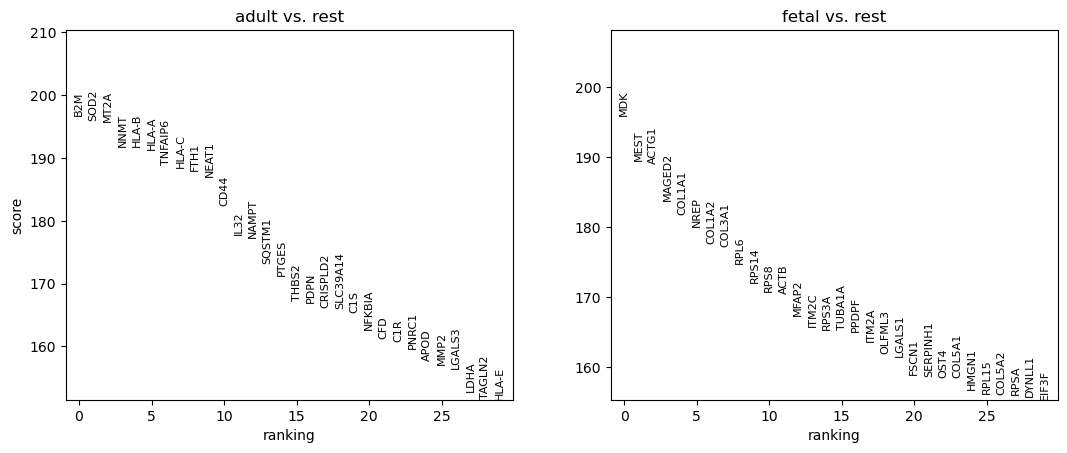

In [21]:
sc.pl.rank_genes_groups(cdata2_fibcombined, n_genes=30, sharey=False, key='rank_genes_groups_fibcombined2')

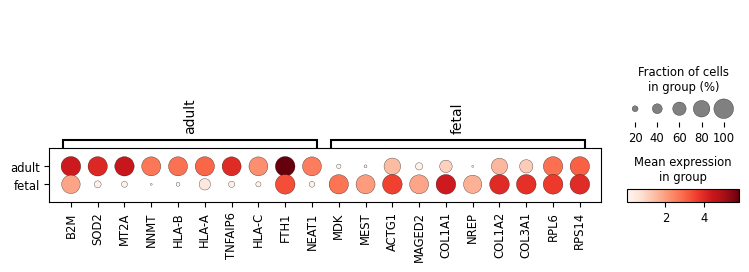

In [22]:
sc.pl.rank_genes_groups_dotplot(cdata2_fibcombined, groups=None, n_genes=10, groupby='dataset', key='rank_genes_groups_fibcombined2')

In [60]:
#df_adfib2_ad_all = sc.get.rank_genes_groups_df(cdata2_fibcombined, group='adult', key='rank_genes_groups_fibcombined2')
#df_adfib2_ad_all.to_csv('/home/jovyan/projects/skin/fetal_skin/ad_fetal_fib2_adall_22032023.csv')
#
#df_adfib2_ft_all = sc.get.rank_genes_groups_df(cdata2_fibcombined, group='fetal', key='rank_genes_groups_fibcombined2')
#df_adfib2_ft_all.to_csv('/home/jovyan/projects/skin/fetal_skin/ad_fetal_fib2_ftall_22032023.csv')
#
#df_adfib2_ad_all.nlargest(1000, 'scores', keep='all').to_csv('/home/jovyan/projects/skin/fetal_skin/ad_fetal_fib_ad_top1000.csv')
#df_adfib2_ft_all.nlargest(1000, 'scores', keep='all').to_csv('/home/jovyan/projects/skin/fetal_skin/ad_fetal_fib_fs_top1000.csv')

### Plotting by celltype

In [26]:
#DEGs looked into, further information from literature
#adult DEGs have pro-inflammatory profile compared to fetal skin DEGs which exhibit an immunosuppressive profiles
#curated list of genes plotted

In [23]:
cdata2_fibcombined.obs['new_combined_anno'].value_counts()

WNT2+ fibroblast           29109
HOXC5+ early fibroblast    15275
FRZB+ early fibroblast     10877
F1                         10161
F2                          4260
PEAR1+ fibroblast           3787
F3                          3035
Name: new_combined_anno, dtype: int64

In [24]:
#reorder cell types
cdata2_fibcombined.obs['new_combined_anno'] = cdata2_fibcombined.obs['new_combined_anno'].cat.reorder_categories([
'FRZB+ early fibroblast', 
'HOXC5+ early fibroblast', 
'WNT2+ fibroblast',
'PEAR1+ fibroblast',
'F1', 
'F2',
'F3'
])

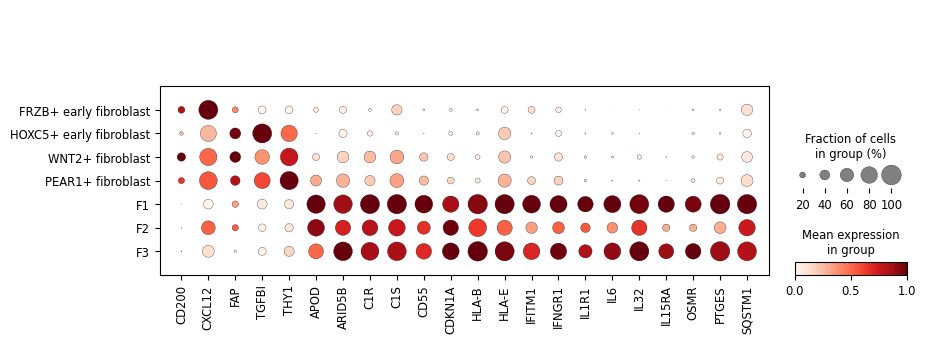

In [25]:
sc.pl.dotplot(cdata2_fibcombined, var_names=['CD200', 'CXCL12', 'FAP', 'TGFBI', 'THY1',
                                             'APOD', 'ARID5B', 'C1R', 'C1S', 'CD55', 'CDKN1A', 'HLA-B', 'HLA-E', 'IFITM1', 'IFNGR1', 'IL1R1', 'IL6', 'IL32', 'IL15RA', 
                                             'OSMR', 'PTGES', 'SQSTM1'], 
              groupby=['new_combined_anno'], standard_scale='var')

#sc.pl.dotplot(cdata2_fibcombined, var_names=['CD200', 'CXCL12', 'FAP', 'TGFBI', 'THY1',
#                                             'APOD', 'ARID5B', 'C1R', 'C1S', 'CD55', 'CDKN1A', 'HLA-B', 'HLA-E', 'IFITM1', 'IFNGR1', 'IL1R1', 'IL6', 'IL32', 'IL15RA', 
#                                             'OSMR', 'PTGES', 'SQSTM1'], 
#              groupby=['new_combined_anno'], standard_scale='var', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/adult_fetal_fib_14102022.pdf')

### Plotting by PCW

In [ ]:
#same gene list as above plotted in prenatal skin fibroblast only by stage (PCW)

In [27]:
#slice to prenatal skin only structural fibroblasts
cdata2_fibft = cdata2_fibcombined[cdata2_fibcombined.obs['dataset'].isin(['fetal'])]
print(list(cdata2_fibft.obs['new_combined_anno'].unique()))

['WNT2+ fibroblast', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'FRZB+ early fibroblast']


In [28]:
print(list(cdata2_fibft.obs['pcw'].unique()))

[8, 9, 10, 7, 13, 16, 12, 15, 11, 14]


In [33]:
cdata2_fibft.obs['pcw'] = cdata2_fibft.obs['pcw'].astype('category')

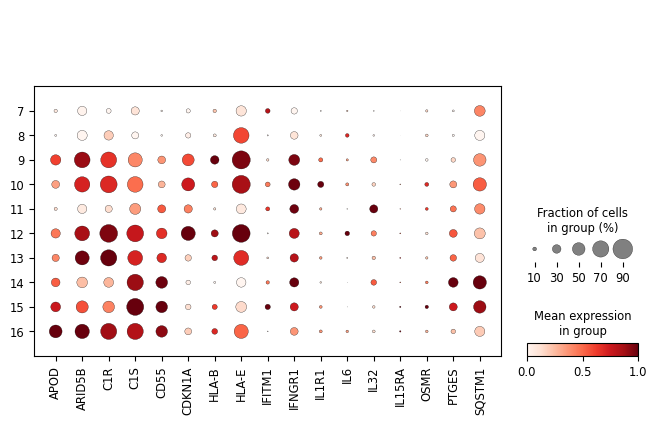

In [34]:
#plot version by PCW
sc.pl.dotplot(cdata2_fibft, var_names=[#'CD200', 'CXCL12', 'FAP', 'TGFBI', 'THY1',
                                             'APOD', 'ARID5B', 'C1R', 'C1S', 'CD55', 'CDKN1A', 'HLA-B', 'HLA-E', 'IFITM1', 'IFNGR1', 'IL1R1', 'IL6', 'IL32', 'IL15RA', 
                                             'OSMR', 'PTGES', 'SQSTM1'], 
              groupby=['pcw'], standard_scale='var')

#sc.pl.dotplot(cdata2_fibft, var_names=[#'CD200', 'CXCL12', 'FAP', 'TGFBI', 'THY1',
#                                             'APOD', 'ARID5B', 'C1R', 'C1S', 'CD55', 'CDKN1A', 'HLA-B', 'HLA-E', 'IFITM1', 'IFNGR1', 'IL1R1', 'IL6', 'IL32', 'IL15RA', 
#                                             'OSMR', 'PTGES', 'SQSTM1'], 
#              groupby=['pcw'], standard_scale='var', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/adult_fetal_fibadult_fetal_fib_byPCW_04032023_2.pdf')